<a href="https://colab.research.google.com/github/Lanxin-Xiang/is765/blob/main/W5a_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W5a. Classification

Ref:

https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb

https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb#scrollTo=Q3nupQL24E5E

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://fasttext.cc/docs/en/supervised-tutorial.html

## Classification task with LSTM

We will use a [sentiment classification dataset on UCI](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) to illustrate how to implement a lstm deep learning model with logit classifier. Download this dataset and import it with code below.

In [1]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/is765

/content/drive/MyDrive/is765


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pprint import pprint
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime
import math

In [4]:
!wget -nc -P data/ https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip # -nc skip if files exist
!unzip -n data/sentiment+labelled+sentences.zip -d data/ # -n skip if files exist

File ‘data/sentiment+labelled+sentences.zip’ already there; not retrieving.

Archive:  data/sentiment+labelled+sentences.zip


Create two numpy arrays to store the texts and labels separately.

In [5]:
text = []
label = []
for line in open("data/sentiment labelled sentences/yelp_labelled.txt"):
    line = line.rstrip('\n').split('\t')
    text.append(line[0])
    label.append(int(line[1]))
text = np.array(text)
label = np.array(label)

In [6]:
num_print = 10
print(np.hstack((text[:num_print].reshape(num_print,1), label[:num_print].reshape(num_print,1))))

[['Wow... Loved this place.' '1']
 ['Crust is not good.' '0']
 ['Not tasty and the texture was just nasty.' '0']
 ['Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'
  '1']
 ['The selection on the menu was great and so were the prices.' '1']
 ['Now I am getting angry and I want my damn pho.' '0']
 ["Honeslty it didn't taste THAT fresh.)" '0']
 ['The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'
  '0']
 ['The fries were great too.' '1']
 ['A great touch.' '1']]


Here we use the `TextVectorization()` function in `keras` to complete basic text processing tasks. See the function documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). In particular, you can control the following things:
- tokenization (split)
- lowercasing and remove puctuation (standardize)
- optionally generate ngrams
- turn into integer representation (output_mode = 'int')
- whether to pad texts of different length to the same sequence length (output_sequence_length)

In [7]:
vectorize_layer = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = None,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = None
)

In [8]:
# apply it to the text data with "adapt"
vectorize_layer.adapt(text)

In [ ]:
# check preprocessing results, such as vocabulary,
vectorize_layer.get_vocabulary()

In [10]:
len(vectorize_layer.get_vocabulary())

2082

Note that the vocabulary contains two special tokens:
- ' ' is called the **padding token**. It is an empty string, correspond to index 0, that can be used to pad texts of different lengths to the same sequence length. When this text vectorization layer is applied to a set of texts, it automatically perform padding (to the longest sequence).
- '[UNK]' is called the **Out-of-Vocabulary token**. It is used to represent any word that does not appear in the vocabulary.

The next block of code is for demonstration purpose only - it is typically NOT needed in actual model building. We want to use `vectorize_layer` to process some texts and represent them as indices in vocabulary.

In [11]:
# now use it to process some text
input_text = [['very good food'], ['language model']]
vectorize_layer(input_text)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[20, 17, 12],
       [ 1,  1,  0]])>

We will demostrate how to use both `tensorboard` and `matplotpy` to visualize the training process. Unlike plotting loss and accuracy with history object, we need to specify our logging directory with callbacks when compiling models.

In [13]:
# install tensorboard if needed

!pip install tensorboard

In [15]:
# load tensorboard for later analysis.
%load_ext tensorboard

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # specify log directory

model = Sequential()
model.add(vectorize_layer)
model.add(Embedding(
    input_dim = len(vectorize_layer.get_vocabulary()),
    output_dim = 64,
    mask_zero = True
))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

checkpoint_callback = ModelCheckpoint(filepath= '/tmp/checkpoint', monitor="val_accuracy", save_best_only=True)
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystopping_callback = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [checkpoint_callback, tensorboard_callback, earlystopping_callback]

We reuse the model introduced in W4b by modifying the structure to complish a classification task. Because we only need a single output at the end of the entire LSTM, we only need to specify the total number of LSTM units in the `LSTM` function.

In [17]:
# configure training / optimization
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss = keras.losses.BinaryCrossentropy(),
                  optimizer=opt,
                  metrics=['accuracy'])

In [18]:
# training with 20% validation and 20 epochs.
history = model.fit(x=text, y=label, validation_split=0.2, epochs=20,
                    batch_size=32, callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/20
25/25 [==============================] - 52s 2s/step - loss: 0.6463 - accuracy: 0.6350 - val_loss: 0.6767 - val_accuracy: 0.5850
Epoch 2/20
25/25 [==============================] - 38s 2s/step - loss: 0.2531 - accuracy: 0.9100 - val_loss: 0.6757 - val_accuracy: 0.7150
Epoch 3/20
25/25 [==============================] - 4s 144ms/step - loss: 0.0926 - accuracy: 0.9700 - val_loss: 0.9656 - val_accuracy: 0.6950
Epoch 4/20
25/25 [==============================] - 23s 951ms/step - loss: 0.0261 - accuracy: 0.9925 - val_loss: 1.0259 - val_accuracy: 0.7500
Epoch 5/20
25/25 [==============================] - 23s 968ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.9893 - val_accuracy: 0.7750
Epoch 6/20
25/25 [==============================] - 2s 94ms/step - loss: 0.0222 - accuracy: 0.9937 - val_loss: 1.1429 - val_accuracy: 0.6750
Epoch 7/20
25/25 [==============================] - 2s 92ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 1.4623 - val_accuracy: 0.7650
Epoch 8/20

**Visualize with plt**

Text(0.5, 1.0, 'Accuracy Curves')

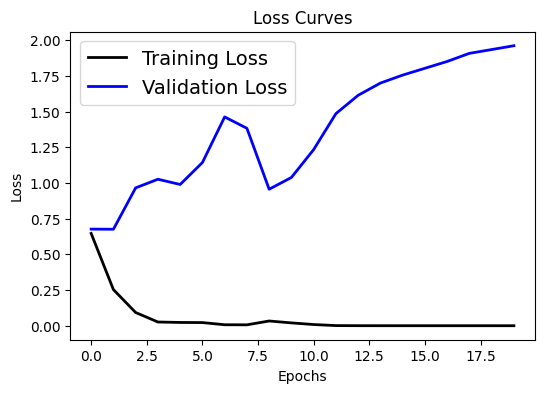

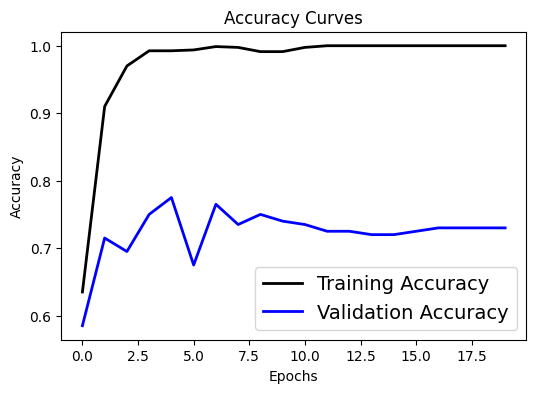

In [19]:
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Plotting the accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

**Use tensorboard to visualize training process**

Load tensorboard with logging data.

You might encounter **403** problem when loading tensorboard. Two possible solutions:

1. Allow third-party coockies on your browser. For chrome users: chrome://settings/cookies

2. Run the `tensorboard dev upload` code |bellow to log in google account and varify identity.

You can find more about how to use tensorboard with Colab [here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb#scrollTo=Q3nupQL24E5E)!

In [20]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [ ]:
# upload tensorboard

!tensorboard dev upload \
  --logdir logs/ \
  --name "(optional) My latest experiment" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot

2023-09-28 18:44:53.187059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/CdtOVrWyTkeGUOdRaKzFGQ/

[2023-09-28T18:44:55] Started scanning logdir.
E0928 18:44:56.790647 139091359760384 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0928 18:44:59.784396 139091359760384 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2023-09-28T18:45:01] Total uploaded: 564 scalars, 0 tensors, 4 binary objects (2.8 MB)
Total skipped: 2 binary objects (1.1 MB)
[2023-09-28T18:45:01] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/CdtOVrWyTkeGUOdRaKzFGQ/


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          133248    
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [40]:
model.save('lstm.classification.keras')

In [41]:
# try to make some predicitons
model.predict([['I hate this meal!'], ['I love this restaurant']])

1/1 [==============================] - 3s 3s/step


array([[0.8484372],
       [0.9999966]], dtype=float32)